# Sample grouping
We are going to linger into the concept of sample groups. As in the previous
section, we will give an example to highlight some surprising results. This
time, we will use the handwritten digits dataset.

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
data, target = digits.data, digits.target

We will recreate the same model used in the previous exercise:
a logistic regression classifier with preprocessor to scale the data.

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1_000))

We will use the same baseline model. We will use a `KFold` cross-validation
without shuffling the data at first.

In [3]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(shuffle=False)
test_score_no_shuffling = cross_val_score(model, data, target, cv=cv,
                                          n_jobs=2)
print(f"The average accuracy is "
      f"{test_score_no_shuffling.mean():.3f} +/- "
      f"{test_score_no_shuffling.std():.3f}")

The average accuracy is 0.931 +/- 0.026


Now, let's repeat the experiment by shuffling the data within the
cross-validation.

In [4]:
cv = KFold(shuffle=True)
test_score_with_shuffling = cross_val_score(model, data, target, cv=cv,
                                            n_jobs=2)
print(f"The average accuracy is "
      f"{test_score_with_shuffling.mean():.3f} +/- "
      f"{test_score_with_shuffling.std():.3f}")

The average accuracy is 0.966 +/- 0.004


We observe that shuffling the data improves the mean accuracy.
We could go a little further and plot the distribution of the testing
score. We can first concatenate the test scores.

In [5]:
import pandas as pd

all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold without shuffling", "KFold with shuffling"],
).T

Let's plot the distribution now.

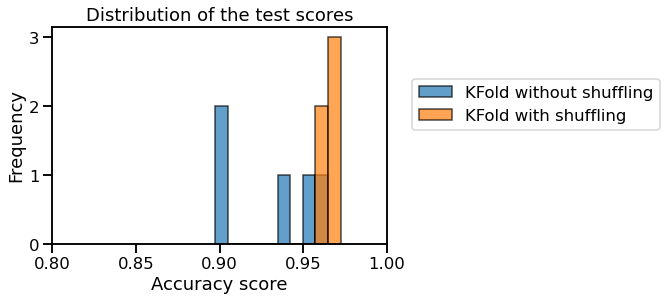

In [6]:
import matplotlib.pyplot as plt

all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

The cross-validation testing error that uses the shuffling has less
variance than the one that does not impose any shuffling. It means that some
specific fold leads to a low score in this case.

In [7]:
print(test_score_no_shuffling)

[0.94166667 0.89722222 0.94986072 0.9637883  0.90250696]


Thus, there is an underlying structure in the data that shuffling will break
and get better results. To get a better understanding, we should read the
documentation shipped with the dataset.

In [8]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

If we read carefully, 13 writers wrote the digits of our dataset, accounting
for a total amount of 1797 samples. Thus, a writer wrote several times the
same numbers. Let's suppose that the writer samples are grouped.
Subsequently, not shuffling the data will keep all writer samples together
either in the training or the testing sets. Mixing the data will break this
structure, and therefore digits written by the same writer will be available
in both the training and testing sets.

Besides, a writer will usually tend to write digits in the same manner. Thus,
our model will learn to identify a writer's pattern for each digit instead of
recognizing the digit itself.

We can solve this problem by ensuring that the data associated with a writer
should either belong to the training or the testing set. Thus, we want to
group samples for each writer.

Indeed, we can recover the groups by looking at the target variable.

In [9]:
target[:200]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6, 6, 6,
       4, 9])


It might not be obvious at first, but there is a structure in the target:
there is a repetitive pattern that always starts by some series of ordered
digits from 0 to 9 followed by random digits at a certain point. If we look
in details, we see that there is 14 such patterns, always with around 130
samples each.

Even if it is not exactly corresponding to the 13 writers in the
documentation (maybe one writer wrote two series of digits), we can
make the hypothesis that each of these patterns corresponds to a different
writer and thus a different group.

In [10]:
from itertools import count
import numpy as np

# defines the lower and upper bounds of sample indices
# for each writer
writer_boundaries = [0, 130, 256, 386, 516, 646, 776, 915, 1029,
                     1157, 1287, 1415, 1545, 1667, 1797]
groups = np.zeros_like(target)
lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

We can check the grouping by plotting the indices linked to writer ids.

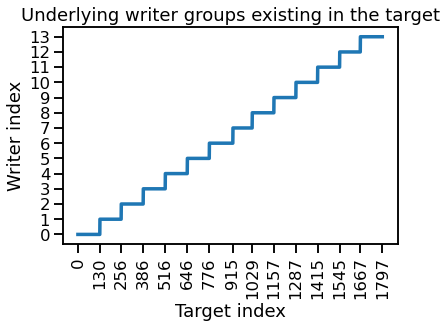

In [11]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Target index")
plt.ylabel("Writer index")
_ = plt.title("Underlying writer groups existing in the target")

Once we group the digits by writer, we can use cross-validation to take this
information into account: the class containing `Group` should be used.

In [12]:
from sklearn.model_selection import GroupKFold

cv = GroupKFold()
test_score = cross_val_score(model, data, target, groups=groups, cv=cv,
                             n_jobs=2)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- "
      f"{test_score.std():.3f}")

The average accuracy is 0.920 +/- 0.021


We see that this strategy is less optimistic regarding the model generalization
performance. However, this is the most reliable if our goal is to make
handwritten digits recognition writers independent. Besides, we can as well
see that the standard deviation was reduced.

In [13]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=["KFold without shuffling", "KFold with shuffling",
           "KFold with groups"],
).T

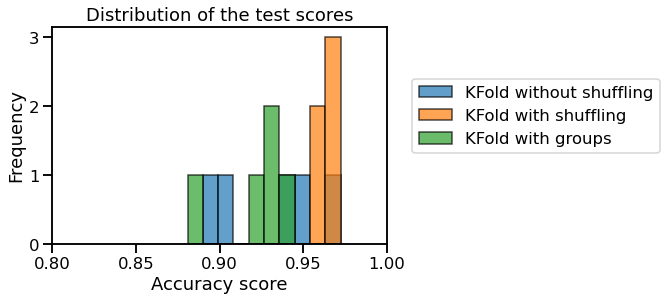

In [14]:
all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

As a conclusion, it is really important to take any sample grouping pattern
into account when evaluating a model. Otherwise, the results obtained will
be over-optimistic in regards with reality.